# Modelling Stock Volatility with Cox-Ingersoll-Ross (CIR) process

In [58]:
# Import dependencies
import time
import math
import numpy as np
import pandas as pd
import datetime
import yfinance as yf
import scipy as sc
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from IPython.display import display, Latex
from statsmodels.graphics.tsaplots import plot_acf

In [59]:
# define start and end dates
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=7000)

# download data
stock_prices = yf.download('^GSPC', start=startDate, end=endDate, interval='1d')

print(startDate)
print(stock_prices.head())


[*********************100%***********************]  1 of 1 completed

2006-06-18 23:09:50.361278
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2006-06-19  1240.130005  1255.930054  1237.170044  1251.540039  2517200000
2006-06-20  1240.119995  1249.010010  1238.869995  1240.119995  2232950000
2006-06-21  1252.199951  1257.959961  1240.089966  1240.089966  2361230000
2006-06-22  1245.599976  1251.920044  1241.530029  1251.920044  2148180000
2006-06-23  1244.500000  1253.130005  1241.430054  1245.589966  2017270000


### Volatility clustering in financial time series

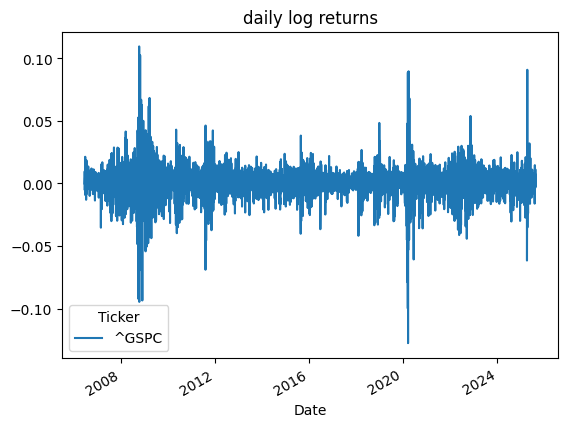

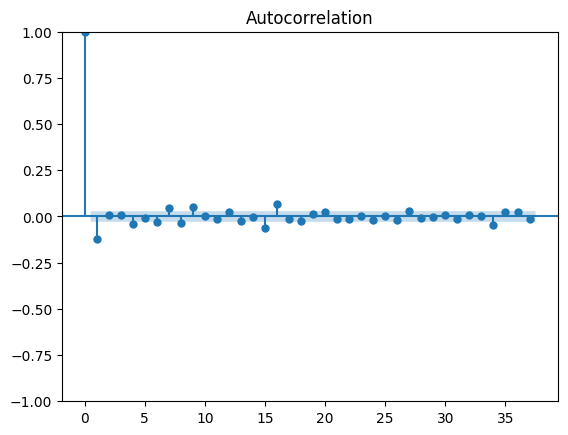

In [60]:
log_returns = np.log(stock_prices.Close/stock_prices.Close.shift(1)).dropna()
log_returns.plot()
plt.title('daily log returns')
plot_acf(log_returns)
plt.show()

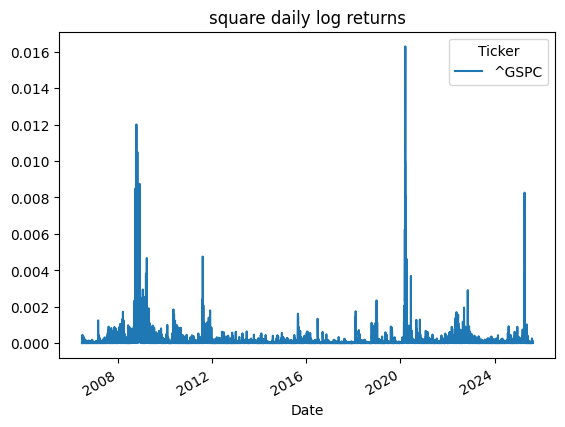

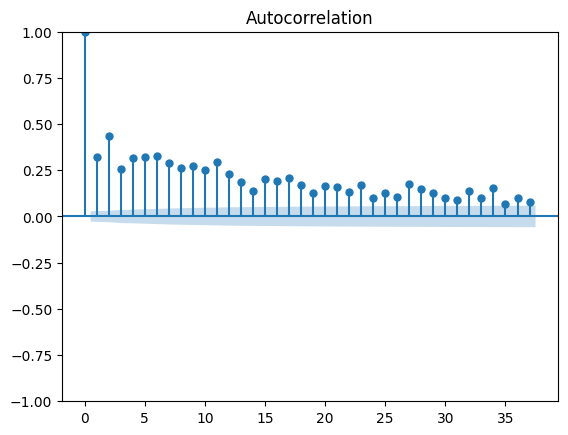

In [61]:
log_returns_sq = np.square(log_returns)
log_returns_sq.plot()
plt.title('square daily log returns')
plot_acf(log_returns_sq)
plt.show()

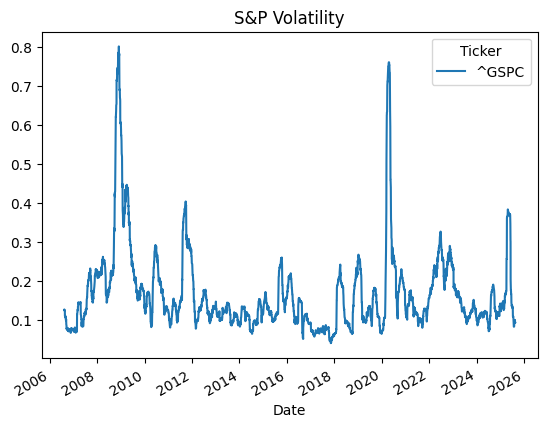

In [62]:
TRADING_DAYS = 40
volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)
volatility = volatility.dropna()
volatility.plot()
plt.title('S&P Volatility')
plt.show()

## Cox-Ingersoll-Ross (CIR)

### Maximum Likelihood Estimation (MLE) of CIR Process

In [63]:
import numpy as np
from scipy.special import ive  # Modified Bessel function of the first kind (scaled)
from scipy.optimize import minimize
import warnings

def log_likelihood_CIR(params, data):
    """
    Log-likelihood function for CIR process with numerical stability improvements
    """
    kappa, theta, xi = params
    
    # Check parameter constraints (Feller condition and positivity)
    if kappa <= 0 or theta <= 0 or xi <= 0:
        return np.inf
    
    # Feller condition: 2*kappa*theta >= xi^2
    if 2 * kappa * theta < xi**2:
        return np.inf
    
    dt = 1/252  # Daily data assumed
    n = len(data) - 1
    V_t = data[:-1]
    V_s = data[1:]
    
    # Check for non-positive volatility values
    if np.any(V_t <= 0) or np.any(V_s <= 0):
        return np.inf
    
    try:
        # CIR transition density parameters
        c = (2 * kappa) / (xi**2 * (1 - np.exp(-kappa * dt)))
        u = c * V_t * np.exp(-kappa * dt)
        v = c * V_s
        q = (2 * kappa * theta) / (xi**2) - 1
        
        # Check for numerical issues
        if c <= 0 or np.any(u <= 0) or np.any(v <= 0):
            return np.inf
        
        # Use scaled modified Bessel function for numerical stability
        sqrt_uv = 2 * np.sqrt(u * v)
        
        # For large arguments, use asymptotic approximation
        large_arg_mask = sqrt_uv > 700
        small_arg_mask = ~large_arg_mask
        
        log_bessel = np.zeros_like(sqrt_uv)
        
        if np.any(small_arg_mask):
            # Use scaled Bessel function ive for numerical stability
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                bessel_vals = ive(q, sqrt_uv[small_arg_mask])
                # ive returns I_v(x) * exp(-|x|), so we need to add |x| back
                log_bessel[small_arg_mask] = np.log(bessel_vals + 1e-300) + sqrt_uv[small_arg_mask]
        
        if np.any(large_arg_mask):
            # Asymptotic approximation for large arguments
            log_bessel[large_arg_mask] = (0.5 * np.log(2 * np.pi / sqrt_uv[large_arg_mask]) + 
                                         sqrt_uv[large_arg_mask] - 
                                         q**2 / (2 * sqrt_uv[large_arg_mask]))
        
        # Calculate log-likelihood
        log_likelihood = (n * np.log(c) + 
                         (q/2) * np.sum(np.log(v / u)) - 
                         np.sum(u + v) + 
                         np.sum(log_bessel))
        
        # Check for NaN or infinite values
        if not np.isfinite(log_likelihood):
            return np.inf
            
        return -log_likelihood  # Return negative for minimization
        
    except Exception as e:
        return np.inf

def estimate_CIR_parameters(volatility_data, method='L-BFGS-B'):
    """
    Estimate CIR process parameters using Maximum Likelihood Estimation
    
    Parameters:
    volatility_data: array of volatility observations
    method: optimization method
    
    Returns:
    dict with estimated parameters and optimization results
    """
    vol = np.array(volatility_data)
    
    # Remove any non-positive values
    vol = vol[vol > 0]
    
    if len(vol) < 2:
        raise ValueError("Need at least 2 positive volatility observations")
    
    # Better initial parameter guesses based on data moments
    vol_mean = np.mean(vol)
    vol_var = np.var(vol)
    vol_diff = np.diff(vol)
    dt = 1/252
    
    # Method of moments initial estimates
    theta_init = vol_mean
    kappa_init = max(0.1, -np.mean(vol_diff) / (dt * vol_mean))
    xi_init = max(0.01, np.sqrt(2 * vol_var * kappa_init / vol_mean))
    
    initial_params = [kappa_init, theta_init, xi_init]
    
    # Multiple starting points for robustness
    starting_points = [
        initial_params,
        [0.5, vol_mean, 0.2],
        [1.0, vol_mean, 0.3],
        [2.0, vol_mean * 0.8, 0.4],
        [0.1, vol_mean * 1.2, 0.1]
    ]
    
    best_result = None
    best_loglik = np.inf
    
    for start_params in starting_points:
        # Bounds ensuring positivity and Feller condition
        bounds = [
            (0.001, 10.0),      # kappa
            (0.001, vol_mean * 3), # theta  
            (0.001, 2.0)        # xi
        ]
        
        try:
            result = minimize(
                log_likelihood_CIR, 
                start_params, 
                args=(vol,), 
                bounds=bounds, 
                method=method,
                options={'maxiter': 1000, 'ftol': 1e-9}
            )
            
            if result.success and result.fun < best_loglik:
                # Check Feller condition for the result
                kappa, theta, xi = result.x
                if 2 * kappa * theta >= xi**2:
                    best_result = result
                    best_loglik = result.fun
                    
        except Exception as e:
            continue
    
    if best_result is None:
        raise RuntimeError("Optimization failed for all starting points")
    
    kappa_mle, theta_mle, xi_mle = best_result.x
    
    # Calculate some diagnostic statistics
    feller_condition = 2 * kappa_mle * theta_mle / (xi_mle**2)
    log_likelihood_value = -best_result.fun
    
    results = {
        'kappa': kappa_mle,
        'theta': theta_mle, 
        'xi': xi_mle,
        'log_likelihood': log_likelihood_value,
        'feller_condition': feller_condition,
        'optimization_success': best_result.success,
        'optimization_result': best_result
    }
    
    return results

# Example usage:
# Assuming you have volatility data
vol_data = np.array(volatility)  # your volatility data
results = estimate_CIR_parameters(vol_data)

print(f"MLE for kappa: {results['kappa']:.6f}")
print(f"MLE for theta: {results['theta']:.6f}") 
print(f"MLE for xi: {results['xi']:.6f}")
print(f"Log-likelihood: {results['log_likelihood']:.4f}")
print(f"Feller condition (should be >= 1): {results['feller_condition']:.4f}")
print(f"Optimization successful: {results['optimization_success']}")

kappa_mle = results['kappa']
theta_mle = results['theta']
xi_mle = results['xi']

MLE for kappa: 0.837578
MLE for theta: 0.164684
MLE for xi: 0.251098
Log-likelihood: 26431.9116
Feller condition (should be >= 1): 4.3754
Optimization successful: True


### Simulating Cox-Ingersoll-Ross (CIR) process:

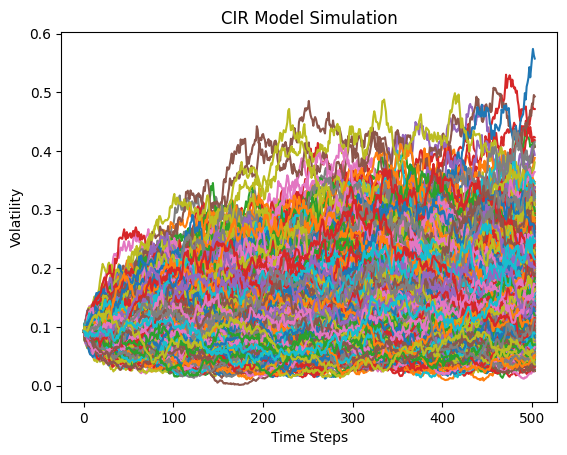

In [66]:
# define parameters
T = 2      # Total time
N = 252*T  # Number of steps
dt = T/N   # Time step
M = 1000   # Number of simulations

V0 = vol[-1] # Initial volatility
Z = np.random.normal(size=(N, M))

vol_cir = np.full(shape=(N, M), fill_value=V0)

for t in range(1,N):
    vol_cir[t] = vol_cir[t-1] + kappa_mle*(theta_mle - vol_cir[t-1])*dt + xi_mle*np.sqrt(vol_cir[t-1])*np.sqrt(dt)*Z[t]

plt.plot(vol_cir)
plt.title('CIR Model Simulation')
plt.ylabel('Volatility')
plt.xlabel('Time Steps')
plt.show()

### Model Selection Criteria: AIC and BIC for CIR Model


In [ ]:
import numpy as np
import pandas as pd
from scipy.special import ive, iv
from scipy import stats
import warnings

def calculate_aic_bic_cir(vol_data, kappa, theta, xi, dt=1/252):
    """
    Calculate AIC and BIC for Cox-Ingersoll-Ross (CIR) model
    
    Parameters:
    vol_data: volatility time series data (should be volatility, not variance)
    kappa: speed of mean reversion parameter
    theta: long-term mean parameter  
    xi: volatility of volatility parameter
    dt: time step (default 1/252 for daily data)
    
    Returns:
    dict with AIC, BIC, log_likelihood, n_params, n_observations
    """
    
    # Ensure we have positive volatility values
    vol_data = np.array(vol_data)
    vol_data = vol_data[vol_data > 0]
    
    if len(vol_data) < 2:
        raise ValueError("Need at least 2 positive volatility observations")
    
    V_t = vol_data[:-1]  # V_t
    V_s = vol_data[1:]   # V_{t+dt}
    n_observations = len(V_t)
    
    # Check parameter constraints
    if kappa <= 0 or theta <= 0 or xi <= 0:
        return {
            'log_likelihood': -np.inf,
            'aic': np.inf,
            'bic': np.inf,
            'n_params': 3,
            'n_observations': n_observations,
            'aic_corrected': np.inf,
            'valid': False
        }
    
    # Feller condition check
    if 2 * kappa * theta < xi**2:
        warnings.warn("Feller condition violated: 2κθ < ξ²")
    
    try:
        # CIR transition density parameters
        c = (2 * kappa) / (xi**2 * (1 - np.exp(-kappa * dt)))
        u = c * V_t * np.exp(-kappa * dt)
        v = c * V_s
        q = (2 * kappa * theta) / (xi**2) - 1
        
        # Check for numerical issues
        if c <= 0 or np.any(u <= 0) or np.any(v <= 0):
            raise ValueError("Invalid parameters leading to negative intermediate values")
        
        # Calculate log-likelihood using stable numerical methods
        sqrt_uv = 2 * np.sqrt(u * v)
        
        # Handle Bessel function evaluation with numerical stability
        log_bessel_terms = np.zeros_like(sqrt_uv)
        
        # For small arguments, use regular Bessel function
        small_mask = sqrt_uv <= 700
        if np.any(small_mask):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                bessel_vals = ive(q, sqrt_uv[small_mask])  # Scaled Bessel function
                # ive returns I_v(x) * exp(-|x|), so we add |x| back for log(I_v(x))
                log_bessel_terms[small_mask] = np.log(bessel_vals + 1e-300) + sqrt_uv[small_mask]
        
        # For large arguments, use asymptotic approximation
        large_mask = ~small_mask
        if np.any(large_mask):
            log_bessel_terms[large_mask] = (sqrt_uv[large_mask] - 
                                          0.5 * np.log(2 * np.pi * sqrt_uv[large_mask]) +
                                          0.125 * (1 - 4*q**2) / sqrt_uv[large_mask])
        
        # Calculate total log-likelihood
        log_likelihood = (n_observations * np.log(c) + 
                         (q/2) * np.sum(np.log(v / u)) - 
                         np.sum(u + v) + 
                         np.sum(log_bessel_terms))
        
        # Check for finite result
        if not np.isfinite(log_likelihood):
            raise ValueError("Log-likelihood calculation resulted in non-finite value")
            
    except Exception as e:
        return {
            'log_likelihood': -np.inf,
            'aic': np.inf,
            'bic': np.inf,
            'n_params': 3,
            'n_observations': n_observations,
            'aic_corrected': np.inf,
            'valid': False,
            'error': str(e)
        }
    
    # Model parameters
    n_params = 3  # kappa, theta, xi
    
    # Calculate AIC and BIC
    aic = 2 * n_params - 2 * log_likelihood
    bic = n_params * np.log(n_observations) - 2 * log_likelihood
    
    # AIC corrected for small sample sizes
    if n_observations > n_params + 1:
        aic_corrected = aic + (2 * n_params * (n_params + 1)) / (n_observations - n_params - 1)
    else:
        aic_corrected = np.inf
    
    return {
        'log_likelihood': log_likelihood,
        'aic': aic,
        'bic': bic,
        'n_params': n_params,
        'n_observations': n_observations,
        'aic_corrected': aic_corrected,
        'valid': True
    }

def compare_volatility_models(vol_data, cir_params=None):
    """
    Compare CIR model with alternative volatility models
    
    Parameters:
    vol_data: volatility time series
    cir_params: tuple of (kappa, theta, xi) for CIR model
    
    Returns:
    DataFrame comparing different models
    """
    
    models_results = {}
    
    # CIR Model (if parameters provided)
    if cir_params is not None:
        kappa, theta, xi = cir_params
        models_results['CIR'] = calculate_aic_bic_cir(vol_data, kappa, theta, xi)
    
    # Random Walk Model
    def calc_random_walk():
        returns = np.diff(vol_data)
        returns = returns[np.isfinite(returns)]
        if len(returns) == 0:
            return {'log_likelihood': -np.inf, 'aic': np.inf, 'bic': np.inf, 'n_params': 2, 'n_observations': 0}
        
        mu_rw = np.mean(returns)
        sigma_rw = np.std(returns, ddof=1)
        
        if sigma_rw <= 0:
            return {'log_likelihood': -np.inf, 'aic': np.inf, 'bic': np.inf, 'n_params': 2, 'n_observations': len(returns)}
        
        log_likelihood = np.sum(stats.norm.logpdf(returns, loc=mu_rw, scale=sigma_rw))
        n_params = 2
        n_observations = len(returns)
        
        aic = 2 * n_params - 2 * log_likelihood
        bic = n_params * np.log(n_observations) - 2 * log_likelihood
        
        return {
            'log_likelihood': log_likelihood,
            'aic': aic,
            'bic': bic,
            'n_params': n_params,
            'n_observations': n_observations
        }
    
    models_results['Random_Walk'] = calc_random_walk()
    
    # AR(1) Model
    def calc_ar1():
        try:
            from statsmodels.tsa.arima.model import ARIMA
            vol_clean = vol_data[np.isfinite(vol_data)]
            if len(vol_clean) < 3:
                return {'log_likelihood': -np.inf, 'aic': np.inf, 'bic': np.inf, 'n_params': 3, 'n_observations': len(vol_clean)}
            
            model = ARIMA(vol_clean, order=(1,0,0))
            fitted_model = model.fit(disp=False)
            
            return {
                'log_likelihood': fitted_model.llf,
                'aic': fitted_model.aic,
                'bic': fitted_model.bic,
                'n_params': len(fitted_model.params),
                'n_observations': len(vol_clean)
            }
        except:
            return {'log_likelihood': -np.inf, 'aic': np.inf, 'bic': np.inf, 'n_params': 3, 'n_observations': len(vol_data)}
    
    models_results['AR(1)'] = calc_ar1()
    
    # Constant Volatility Model
    def calc_constant():
        vol_clean = vol_data[np.isfinite(vol_data)]
        if len(vol_clean) == 0:
            return {'log_likelihood': -np.inf, 'aic': np.inf, 'bic': np.inf, 'n_params': 2, 'n_observations': 0}
        
        mu_const = np.mean(vol_clean)
        sigma_const = np.std(vol_clean, ddof=1)
        
        if sigma_const <= 0:
            return {'log_likelihood': -np.inf, 'aic': np.inf, 'bic': np.inf, 'n_params': 2, 'n_observations': len(vol_clean)}
        
        log_likelihood = np.sum(stats.norm.logpdf(vol_clean, loc=mu_const, scale=sigma_const))
        n_params = 2
        n_observations = len(vol_clean)
        
        aic = 2 * n_params - 2 * log_likelihood
        bic = n_params * np.log(n_observations) - 2 * log_likelihood
        
        return {
            'log_likelihood': log_likelihood,
            'aic': aic,
            'bic': bic,
            'n_params': n_params,
            'n_observations': n_observations
        }
    
    models_results['Constant_Vol'] = calc_constant()
    
    # Create comparison DataFrame
    comparison_data = []
    for model_name, metrics in models_results.items():
        comparison_data.append({
            'Model': model_name,
            'Log_Likelihood': metrics['log_likelihood'],
            'AIC': metrics['aic'],
            'BIC': metrics['bic'],
            'N_params': metrics['n_params'],
            'N_obs': metrics['n_observations']
        })
    
    df = pd.DataFrame(comparison_data)
    
    # Add rankings (excluding infinite values)
    finite_aic = df['AIC'][np.isfinite(df['AIC'])]
    finite_bic = df['BIC'][np.isfinite(df['BIC'])]
    
    if len(finite_aic) > 0:
        df['AIC_rank'] = df['AIC'].rank(method='min')
    if len(finite_bic) > 0:
        df['BIC_rank'] = df['BIC'].rank(method='min')
    
    return df.sort_values('AIC')

def print_cir_diagnostics(kappa, theta, xi, vol_data):
    """
    Print diagnostic information for CIR model
    """
    print(f"\nCIR Model Parameters:")
    print(f"κ (mean reversion speed): {kappa:.6f}")
    print(f"θ (long-term mean): {theta:.6f}")
    print(f"ξ (volatility of volatility): {xi:.6f}")
    
    # Feller condition
    feller_value = 2 * kappa * theta / (xi**2)
    feller_satisfied = feller_value >= 1
    print(f"\nFeller condition (2κθ/ξ²): {feller_value:.4f} {'✓' if feller_satisfied else '✗'}")
    print(f"Condition satisfied: {feller_satisfied}")
    
    # Mean reversion half-life
    half_life = np.log(2) / kappa if kappa > 0 else np.inf
    print(f"Mean reversion half-life: {half_life:.1f} days")
    
    # Long-term volatility
    print(f"Long-term volatility: {theta*100:.2f}%")
    
    # Current vs long-term volatility
    current_vol = vol_data[-1] if len(vol_data) > 0 else np.nan
    print(f"Current volatility: {current_vol*100:.2f}%")
    
    # Unconditional variance and volatility
    if feller_satisfied:
        unconditional_var = theta
        unconditional_vol = np.sqrt(theta)
        print(f"Unconditional volatility: {unconditional_vol*100:.2f}%")

np.random.seed(42)
T = 1
N = 252
dt = T/N

# True parameters
kappa_true = 2.0
theta_true = 0.04
xi_true = 0.3

# Simulate CIR process
V = np.zeros(N)
V[0] = theta_true

for t in range(1, N):
    dW = np.random.normal(0, np.sqrt(dt))
    V[t] = V[t-1] + kappa_true * (theta_true - V[t-1]) * dt + xi_true * np.sqrt(max(V[t-1], 0)) * dW
    V[t] = max(V[t], 1e-6)  # Ensure positivity

# Calculate AIC and BIC
results = calculate_aic_bic_cir(V, kappa_true, theta_true, xi_true)
print("CIR Model Results:")
for key, value in results.items():
    if key != 'error':
        print(f"{key}: {value}")

# Compare with other models
comparison = compare_volatility_models(V, (kappa_true, theta_true, xi_true))
print("\nModel Comparison:")
print(comparison)

CIR Model Results:
log_likelihood: 1109.5454951902939
aic: -2213.0909903805878
bic: -2202.5146315631923
n_params: 3
n_observations: 251
aic_corrected: -2212.993824388685
valid: True

Model Comparison:
          Model  Log_Likelihood          AIC          BIC  N_params  N_obs  \
0           CIR     1109.545495 -2213.090990 -2202.514632         3    251   
1   Random_Walk     1085.410001 -2166.820003 -2159.769097         2    251   
3  Constant_Vol      698.622015 -1393.244030 -1386.185171         2    252   
2         AR(1)            -inf          inf          inf         3    252   

   AIC_rank  BIC_rank  
0       1.0       1.0  
1       2.0       2.0  
3       3.0       3.0  
2       4.0       4.0  
